In [2]:
import nibabel as nb
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np 

import torch 
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split
from datetime import datetime

import utils

In [3]:
#Unet CLASICA (nuevo formato)

class DownConv(nn.Module):
    
    def __init__(self, in_channels , out_channels):
        super(DownConv, self).__init__()
        self.DownLayer = nn.Sequential(

            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace = True),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace = True),
        )
        
    def forward(self, x ):
        x = self.DownLayer(x)
        return x
    
        
class MaxPool(nn.Module):
    def __init__(self):
        super(MaxPool, self).__init__()
        self.Pool = torch.nn.MaxPool2d(kernel_size = 2)
        
    def forward (self,x):
        x = self.Pool(x)
        return x
    
        
class UpConv(nn.Module):
    
    def __init__(self, in_channels , out_channels):
        super(UpConv, self).__init__()
        
        self.ConvTransp = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        #self.ConvTransp = torch.nn.ConvTranspose2d((in_channels//2), out_channels, kernel_size = 2, stride = 2, padding = 0)
        self.UpConv = DownConv(in_channels, out_channels)
        
    def forward(self, xAnt , xDown):
            
        layerConvTransposed = self.ConvTransp(xAnt)
        concat = torch.cat([layerConvTransposed,xDown], dim=1)
        x = self.UpConv(concat)
            
        return x

class OutUnet(nn.Module):
    def __init__(self, in_channels , out_channels):
        super(OutUnet, self).__init__()
        self.OutUnet = torch.nn.Conv2d(in_channels,out_channels, kernel_size = 1)
        
    def forward(self,x):
        x = self.OutUnet(x)
        return x

class Unet(nn.Module):
    
    def __init__(self):
        super(Unet,self).__init__()
        
        # Contract
        self.Layer1Down = DownConv(1,32)
        self.Layer2Down = DownConv(32,64)
        self.Layer3Down = DownConv(64,128)
        self.Layer4Down = DownConv(128,256)
        self.Layer5Down = DownConv(256,512)
        
        self.Middle = DownConv(512,512)
        
        self.Layer1Up = UpConv(1024,256)
        self.Layer2Up = UpConv(512,128)
        self.Layer3Up = UpConv(256,64)
        self.Layer4Up = UpConv(128,64)
        self.Layer5Up = UpConv(64+32,32)
        
        self.MaxPool = MaxPool()
        
        self.Out = OutUnet(32,1)
        
        
    
    def forward(self, x):

        # Down
        conv1 = self.Layer1Down(x)
        maxPool1 = self.MaxPool(conv1)
        
        conv2 = self.Layer2Down(maxPool1)
        maxPool2 = self.MaxPool(conv2)
        
        conv3 = self.Layer3Down(maxPool2)
        maxPool3 = self.MaxPool(conv3)
        
        conv4 = self.Layer4Down(maxPool3)
        maxPool4 = self.MaxPool(conv4)
        
        conv5 = self.Layer5Down(maxPool4)
        maxPool5 = self.MaxPool(conv5)
        
        middle = self.Middle(maxPool5)
        
        # Up
        up1= self.Layer1Up(middle,conv5)
        up2= self.Layer2Up(up1,conv4)
        up3= self.Layer3Up(up2,conv3)
        up4= self.Layer4Up(up3,conv2)
        up5= self.Layer5Up(up4,conv1)
        
        outUNet = self.Out(up5)
        
        return outUNet

unet = Unet()

In [49]:
# Importo base de datos

noisyDataSet1_nii = sitk.ReadImage('./noisyDataSet1.nii')
img_noisyDataSet1 = sitk.GetArrayFromImage(noisyDataSet1_nii)

noisyDataSet2_nii = sitk.ReadImage('./noisyDataSet2.nii')
img_noisyDataSet2 = sitk.GetArrayFromImage(noisyDataSet2_nii)

groundTruth_nii = sitk.ReadImage('./groundTruth.nii')
img_groundTruth = sitk.GetArrayFromImage(groundTruth_nii)

print("noisyDataSet1 shape:",img_noisyDataSet1.shape)
print("noisyDataSet2 shape:",img_noisyDataSet2.shape)
print("groundTruth shape:",img_groundTruth.shape)

noisyDataSet1 shape: (1726, 344, 344)
noisyDataSet2 shape: (1726, 344, 344)
groundTruth shape: (1726, 344, 344)


In [50]:
# Reshape for training

img_noisyDataSet1 =img_noisyDataSet1[:,44:300,44:300]
img_noisyDataSet2 =img_noisyDataSet2[:,44:300,44:300]
img_groundTruth =img_groundTruth[:,44:300,44:300]


img_noisyDataSet1 = (np.expand_dims(img_noisyDataSet1, axis=-3)).astype(np.float32)
img_noisyDataSet2 = (np.expand_dims(img_noisyDataSet2, axis=-3)).astype(np.float32)
img_groundTruth = (np.expand_dims(img_groundTruth, axis=-3)).astype(np.float32)

print(img_noisyDataSet1.shape)
print(img_noisyDataSet2.shape)
print(img_groundTruth.shape)

(1726, 1, 256, 256)
(1726, 1, 256, 256)
(1726, 1, 256, 256)


In [51]:
# Conjunto de entrenamiento, testeo y validacion

train_noisyImage,valid_noisyImage,train_groundTruth,valid_groundTruth = train_test_split(img_noisyDataSet1, img_groundTruth, test_size=0.3)

# Create dictionaries with training sets:
trainingSet = dict([('input',train_noisyImage), ('output', train_groundTruth)])
validSet = dict([('input',valid_noisyImage), ('output', valid_groundTruth)])

print('Data set size. Training set: {0}. Valid set: {1}.'.format(trainingSet['input'].shape[0], validSet['input'].shape[0]))

# Entrenamiento #

# Loss and optimizer

criterion = nn.MSELoss()
optimizer = optim.Adam(unet.parameters(), lr=0.0001)

Data set size. Training set: 1208. Valid set: 518.


In [8]:
# Entrenamiento #

# Loss and optimizer

criterion = nn.MSELoss()
optimizer = optim.Adam(unet.parameters(), lr=0.0001)

# Codigo entrenamiento Martin

# defino batches

best_vloss = 1000000000

batchSizeTrain = 4
batchSizeValid = 4
numBatchesTrain = np.round(trainingSet['input'].shape[0] / batchSizeTrain).astype(int)
numBatchesValid = np.round(validSet['input'].shape[0] / batchSizeValid).astype(int)

# Show dev set loss every showDevLossStep batches:
showDevLossStep = 4

printStep = 1
# figImages, axs = plt.subplots(3, 1,figsize=(20,20))
# figLoss, axLoss = plt.subplots(1, 1,figsize=(5,5))

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# Train
loss_values = []
lossValuesTrainingSet = []
iterationNumbers = []
lossValuesDevSet = []
iterationNumbersForDevSet = []
lossValuesTrainingSetEpoch = []

lossValuesEpoch = []

iter = 0

EPOCHS = 20

for epoch in range(EPOCHS):  # loop over the dataset multiple times
    
    lossValuesTrainingSetEpoch = []
    lossValuesDevSetEpoch = []

    running_loss = 0.0

    unet.train(True)
    for i in range(numBatchesTrain):
        # get the inputs

        inputs = torch.from_numpy(trainingSet['input'][i * batchSizeTrain:(i + 1) * batchSizeTrain, :, :, :])
        gt = torch.from_numpy(trainingSet['output'][i * batchSizeTrain:(i + 1) * batchSizeTrain, :, :, :])

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = unet(inputs)
        loss = criterion(outputs, gt)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # Save loss values:
        lossValuesTrainingSet.append(loss.item())
        lossValuesTrainingSetEpoch.append(loss.item())
        iterationNumbers.append(iter)

        if i % printStep == (printStep - 1):  # print every printStep mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss))
            running_loss = 0.0

            # Show input images:
            # plt.figure(figImages)
            # plt.axes(axs[0])
            # imshow(torchvision.utils.make_grid(inputs, normalize=True))
            # axs[0].set_title('Input Batch {0}'.format(i))
            # plt.axes(axs[1])
            # imshow(torchvision.utils.make_grid(outputs, normalize=True))
            # axs[1].set_title('Output Epoch {0}'.format(epoch))
            # plt.axes(axs[2])
            # imshow(torchvision.utils.make_grid(gt, normalize=True))
            # axs[2].set_title('Ground Truth')
            # Show loss:
            # plt.figure(figLoss)
            # axLoss.plot(iterationNumbers, lossValuesTrainingSet)
            # axLoss.plot(iterationNumbersForDevSet, lossValuesDevSet)
            # plt.draw()
            # plt.pause(0.0001)

            # Update iteration number:
        iter = iter + 1

    lossValuesEpoch.append(np.mean(lossValuesTrainingSetEpoch))
    unet.train(False)
    running_vloss = 0.0


    for i in range(numBatchesValid):
        print(i)

        vinputs = torch.from_numpy(validSet['input'][i * batchSizeValid:(i + 1) * batchSizeValid, :, :, :])
        vgt = torch.from_numpy(validSet['output'][i * batchSizeValid:(i + 1) * batchSizeValid, :, :, :])

        voutputs = unet(vinputs)
        vloss = criterion(voutputs, vgt)
        vloss.backward()
        running_vloss += vloss

        lossValuesDevSet.append(vloss.item())
        
        lossValuesDevSetEpoch.append(vloss.item())


    avg_vloss = np.mean(lossValuesDevSet)
    lossValuesDevSetEpoch.append(np.mean(lossValuesDevSetEpoch))

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch)
        torch.save(unet.state_dict(), model_path)

    print('LOSS train {} valid {}'.format(lossValuesTrainingSet[-1], avg_vloss))

print('Finished Training')

[1,     1] loss: 0.709
[1,     2] loss: 1.065
[1,     3] loss: 0.469
[1,     4] loss: 1.272
[1,     5] loss: 0.883
[1,     6] loss: 0.794
[1,     7] loss: 0.313
[1,     8] loss: 0.242
[1,     9] loss: 0.463
[1,    10] loss: 0.790
[1,    11] loss: 0.499
[1,    12] loss: 0.255
[1,    13] loss: 0.815
[1,    14] loss: 0.367
[1,    15] loss: 0.526
[1,    16] loss: 0.258
[1,    17] loss: 0.366
[1,    18] loss: 0.208
[1,    19] loss: 0.239
[1,    20] loss: 0.209
[1,    21] loss: 0.168
[1,    22] loss: 0.200
[1,    23] loss: 0.280
[1,    24] loss: 0.195
[1,    25] loss: 0.185
[1,    26] loss: 0.351
[1,    27] loss: 0.230
[1,    28] loss: 0.215
[1,    29] loss: 0.193
[1,    30] loss: 0.185
[1,    31] loss: 0.169
[1,    32] loss: 0.376
[1,    33] loss: 0.156
[1,    34] loss: 0.358
[1,    35] loss: 0.130
[1,    36] loss: 0.173
[1,    37] loss: 0.240
[1,    38] loss: 0.243
[1,    39] loss: 0.218
[1,    40] loss: 0.146
[1,    41] loss: 0.335
[1,    42] loss: 0.273
[1,    43] loss: 0.156
[1,    44] 

[2,    35] loss: 0.064
[2,    36] loss: 0.068
[2,    37] loss: 0.092
[2,    38] loss: 0.097
[2,    39] loss: 0.092
[2,    40] loss: 0.082
[2,    41] loss: 0.144
[2,    42] loss: 0.114
[2,    43] loss: 0.074
[2,    44] loss: 0.059
[2,    45] loss: 0.084
[2,    46] loss: 0.102
[2,    47] loss: 0.060
[2,    48] loss: 0.072
[2,    49] loss: 0.105
[2,    50] loss: 0.068
[2,    51] loss: 0.064
[2,    52] loss: 0.107
[2,    53] loss: 0.059
[2,    54] loss: 0.059
[2,    55] loss: 0.099
[2,    56] loss: 0.053
[2,    57] loss: 0.071
[2,    58] loss: 0.086
[2,    59] loss: 0.054
[2,    60] loss: 0.152
[2,    61] loss: 0.112
[2,    62] loss: 0.128
[2,    63] loss: 0.079
[2,    64] loss: 0.121
[2,    65] loss: 0.098
[2,    66] loss: 0.084
[2,    67] loss: 0.081
[2,    68] loss: 0.086
[2,    69] loss: 0.145
[2,    70] loss: 0.108
[2,    71] loss: 0.074
[2,    72] loss: 0.116
[2,    73] loss: 0.093
[2,    74] loss: 0.068
[2,    75] loss: 0.083
[2,    76] loss: 0.122
[2,    77] loss: 0.072
[2,    78] 

[3,    69] loss: 0.106
[3,    70] loss: 0.085
[3,    71] loss: 0.066
[3,    72] loss: 0.094
[3,    73] loss: 0.079
[3,    74] loss: 0.055
[3,    75] loss: 0.066
[3,    76] loss: 0.093
[3,    77] loss: 0.062
[3,    78] loss: 0.080
[3,    79] loss: 0.038
[3,    80] loss: 0.080
[3,    81] loss: 0.074
[3,    82] loss: 0.049
[3,    83] loss: 0.087
[3,    84] loss: 0.039
[3,    85] loss: 0.070
[3,    86] loss: 0.076
[3,    87] loss: 0.087
[3,    88] loss: 0.067
[3,    89] loss: 0.045
[3,    90] loss: 0.047
[3,    91] loss: 0.122
[3,    92] loss: 0.068
[3,    93] loss: 0.097
[3,    94] loss: 0.082
[3,    95] loss: 0.042
[3,    96] loss: 0.040
[3,    97] loss: 0.080
[3,    98] loss: 0.083
[3,    99] loss: 0.094
[3,   100] loss: 0.061
[3,   101] loss: 0.076
[3,   102] loss: 0.061
[3,   103] loss: 0.050
[3,   104] loss: 0.045
[3,   105] loss: 0.072
[3,   106] loss: 0.052
[3,   107] loss: 0.037
[3,   108] loss: 0.054
[3,   109] loss: 0.056
[3,   110] loss: 0.059
[3,   111] loss: 0.069
[3,   112] 

[4,   103] loss: 0.047
[4,   104] loss: 0.044
[4,   105] loss: 0.068
[4,   106] loss: 0.049
[4,   107] loss: 0.033
[4,   108] loss: 0.051
[4,   109] loss: 0.053
[4,   110] loss: 0.057
[4,   111] loss: 0.065
[4,   112] loss: 0.089
[4,   113] loss: 0.112
[4,   114] loss: 0.064
[4,   115] loss: 0.054
[4,   116] loss: 0.068
[4,   117] loss: 0.069
[4,   118] loss: 0.070
[4,   119] loss: 0.078
[4,   120] loss: 0.067
[4,   121] loss: 0.049
[4,   122] loss: 0.069
[4,   123] loss: 0.036
[4,   124] loss: 0.051
[4,   125] loss: 0.039
[4,   126] loss: 0.035
[4,   127] loss: 0.061
[4,   128] loss: 0.069
[4,   129] loss: 0.071
[4,   130] loss: 0.062
[4,   131] loss: 0.060
[4,   132] loss: 0.061
[4,   133] loss: 0.046
[4,   134] loss: 0.109
[4,   135] loss: 0.051
[4,   136] loss: 0.071
[4,   137] loss: 0.038
[4,   138] loss: 0.034
[4,   139] loss: 0.074
[4,   140] loss: 0.031
[4,   141] loss: 0.081
[4,   142] loss: 0.063
[4,   143] loss: 0.069
[4,   144] loss: 0.061
[4,   145] loss: 0.074
[4,   146] 

[5,   137] loss: 0.037
[5,   138] loss: 0.033
[5,   139] loss: 0.072
[5,   140] loss: 0.029
[5,   141] loss: 0.078
[5,   142] loss: 0.061
[5,   143] loss: 0.067
[5,   144] loss: 0.059
[5,   145] loss: 0.070
[5,   146] loss: 0.079
[5,   147] loss: 0.047
[5,   148] loss: 0.060
[5,   149] loss: 0.041
[5,   150] loss: 0.058
[5,   151] loss: 0.057
[5,   152] loss: 0.066
[5,   153] loss: 0.078
[5,   154] loss: 0.064
[5,   155] loss: 0.046
[5,   156] loss: 0.031
[5,   157] loss: 0.074
[5,   158] loss: 0.019
[5,   159] loss: 0.072
[5,   160] loss: 0.060
[5,   161] loss: 0.053
[5,   162] loss: 0.042
[5,   163] loss: 0.063
[5,   164] loss: 0.051
[5,   165] loss: 0.036
[5,   166] loss: 0.057
[5,   167] loss: 0.126
[5,   168] loss: 0.072
[5,   169] loss: 0.073
[5,   170] loss: 0.027
[5,   171] loss: 0.037
[5,   172] loss: 0.079
[5,   173] loss: 0.096
[5,   174] loss: 0.082
[5,   175] loss: 0.048
[5,   176] loss: 0.041
[5,   177] loss: 0.080
[5,   178] loss: 0.031
[5,   179] loss: 0.064
[5,   180] 

[6,   171] loss: 0.033
[6,   172] loss: 0.071
[6,   173] loss: 0.083
[6,   174] loss: 0.076
[6,   175] loss: 0.047
[6,   176] loss: 0.041
[6,   177] loss: 0.077
[6,   178] loss: 0.031
[6,   179] loss: 0.063
[6,   180] loss: 0.065
[6,   181] loss: 0.069
[6,   182] loss: 0.071
[6,   183] loss: 0.063
[6,   184] loss: 0.059
[6,   185] loss: 0.062
[6,   186] loss: 0.089
[6,   187] loss: 0.051
[6,   188] loss: 0.056
[6,   189] loss: 0.073
[6,   190] loss: 0.129
[6,   191] loss: 0.026
[6,   192] loss: 0.056
[6,   193] loss: 0.023
[6,   194] loss: 0.079
[6,   195] loss: 0.059
[6,   196] loss: 0.074
[6,   197] loss: 0.027
[6,   198] loss: 0.072
[6,   199] loss: 0.072
[6,   200] loss: 0.043
[6,   201] loss: 0.042
[6,   202] loss: 0.029
[6,   203] loss: 0.045
[6,   204] loss: 0.061
[6,   205] loss: 0.080
[6,   206] loss: 0.056
[6,   207] loss: 0.042
[6,   208] loss: 0.063
[6,   209] loss: 0.059
[6,   210] loss: 0.090
[6,   211] loss: 0.064
[6,   212] loss: 0.051
[6,   213] loss: 0.039
[6,   214] 

[7,   205] loss: 0.078
[7,   206] loss: 0.054
[7,   207] loss: 0.040
[7,   208] loss: 0.062
[7,   209] loss: 0.058
[7,   210] loss: 0.086
[7,   211] loss: 0.063
[7,   212] loss: 0.051
[7,   213] loss: 0.039
[7,   214] loss: 0.059
[7,   215] loss: 0.051
[7,   216] loss: 0.060
[7,   217] loss: 0.039
[7,   218] loss: 0.035
[7,   219] loss: 0.081
[7,   220] loss: 0.077
[7,   221] loss: 0.053
[7,   222] loss: 0.050
[7,   223] loss: 0.076
[7,   224] loss: 0.083
[7,   225] loss: 0.073
[7,   226] loss: 0.057
[7,   227] loss: 0.089
[7,   228] loss: 0.066
[7,   229] loss: 0.047
[7,   230] loss: 0.043
[7,   231] loss: 0.077
[7,   232] loss: 0.080
[7,   233] loss: 0.067
[7,   234] loss: 0.036
[7,   235] loss: 0.037
[7,   236] loss: 0.065
[7,   237] loss: 0.055
[7,   238] loss: 0.092
[7,   239] loss: 0.057
[7,   240] loss: 0.076
[7,   241] loss: 0.041
[7,   242] loss: 0.052
[7,   243] loss: 0.068
[7,   244] loss: 0.038
[7,   245] loss: 0.094
[7,   246] loss: 0.071
[7,   247] loss: 0.067
[7,   248] 

[8,   239] loss: 0.055
[8,   240] loss: 0.074
[8,   241] loss: 0.040
[8,   242] loss: 0.050
[8,   243] loss: 0.062
[8,   244] loss: 0.037
[8,   245] loss: 0.090
[8,   246] loss: 0.069
[8,   247] loss: 0.068
[8,   248] loss: 0.077
[8,   249] loss: 0.067
[8,   250] loss: 0.045
[8,   251] loss: 0.095
[8,   252] loss: 0.043
[8,   253] loss: 0.066
[8,   254] loss: 0.081
[8,   255] loss: 0.054
[8,   256] loss: 0.059
[8,   257] loss: 0.075
[8,   258] loss: 0.053
[8,   259] loss: 0.047
[8,   260] loss: 0.074
[8,   261] loss: 0.026
[8,   262] loss: 0.057
[8,   263] loss: 0.070
[8,   264] loss: 0.071
[8,   265] loss: 0.038
[8,   266] loss: 0.057
[8,   267] loss: 0.067
[8,   268] loss: 0.028
[8,   269] loss: 0.071
[8,   270] loss: 0.041
[8,   271] loss: 0.067
[8,   272] loss: 0.072
[8,   273] loss: 0.028
[8,   274] loss: 0.037
[8,   275] loss: 0.042
[8,   276] loss: 0.064
[8,   277] loss: 0.071
[8,   278] loss: 0.041
[8,   279] loss: 0.065
[8,   280] loss: 0.035
[8,   281] loss: 0.043
[8,   282] 

[9,   273] loss: 0.026
[9,   274] loss: 0.039
[9,   275] loss: 0.044
[9,   276] loss: 0.063
[9,   277] loss: 0.068
[9,   278] loss: 0.043
[9,   279] loss: 0.065
[9,   280] loss: 0.035
[9,   281] loss: 0.043
[9,   282] loss: 0.042
[9,   283] loss: 0.063
[9,   284] loss: 0.052
[9,   285] loss: 0.063
[9,   286] loss: 0.070
[9,   287] loss: 0.029
[9,   288] loss: 0.030
[9,   289] loss: 0.050
[9,   290] loss: 0.071
[9,   291] loss: 0.044
[9,   292] loss: 0.063
[9,   293] loss: 0.066
[9,   294] loss: 0.061
[9,   295] loss: 0.054
[9,   296] loss: 0.048
[9,   297] loss: 0.030
[9,   298] loss: 0.059
[9,   299] loss: 0.048
[9,   300] loss: 0.053
[9,   301] loss: 0.059
[9,   302] loss: 0.045
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


[10,   295] loss: 0.054
[10,   296] loss: 0.064
[10,   297] loss: 0.030
[10,   298] loss: 0.057
[10,   299] loss: 0.047
[10,   300] loss: 0.055
[10,   301] loss: 0.059
[10,   302] loss: 0.045
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
LOSS train 0.045143287628889084 valid 0.05641193122674639
[11,     1] loss: 0.024
[11,     2] loss: 0.043
[11,     3] loss: 0.029
[11,     4] loss: 0.072
[11,     5] loss: 0.057
[11,     6] loss: 0.057
[11,     7] loss: 0.029
[11,     8] loss: 0.033
[11,     9] loss: 0.047
[11,    10] loss: 0.079
[11,    11] loss: 0.055
[11,    12] loss: 0.038
[11,    13] loss: 0.085
[11,    14] loss: 0.048
[11,

99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
LOSS train 0.04384557157754898 valid 0.05607405476193953
[12,     1] loss: 0.018
[12,     2] loss: 0.043
[12,     3] loss: 0.029
[12,     4] loss: 0.068
[12,     5] loss: 0.058
[12,     6] loss: 0.059
[12,     7] loss: 0.029
[12,     8] loss: 0.032
[12,     9] loss: 0.046
[12,    10] loss: 0.081
[12,    11] loss: 0.056
[12,    12] loss: 0.037
[12,    13] loss: 0.084
[12,    14] loss: 0.046
[12,    15] loss: 0.071
[12,    16] loss: 0.043
[12,    17] loss: 0.050
[12,    18] loss: 0.042
[12,    19] loss: 0.043
[12,    20] loss: 0.040
[12,    21] loss: 0.026
[12,    22] loss: 0.043
[12,    23] loss: 0.054
[12,    24] loss: 0.042
[12,    25] loss: 0.042
[12,    26] loss: 0.057
[12,    27] loss: 0.054
[12,    28] loss: 0.048
[12,    29] loss: 0.055
[12,    30] loss: 0.045
[12,    31] loss: 0.041
[12,    32] loss: 0.070
[12,    33] loss: 0.039
[12,    34] loss: 0.065
[12,

[13,    14] loss: 0.048
[13,    15] loss: 0.068
[13,    16] loss: 0.042
[13,    17] loss: 0.051
[13,    18] loss: 0.040
[13,    19] loss: 0.042
[13,    20] loss: 0.041
[13,    21] loss: 0.026
[13,    22] loss: 0.040
[13,    23] loss: 0.056
[13,    24] loss: 0.040
[13,    25] loss: 0.041
[13,    26] loss: 0.058
[13,    27] loss: 0.052
[13,    28] loss: 0.051
[13,    29] loss: 0.050
[13,    30] loss: 0.046
[13,    31] loss: 0.040
[13,    32] loss: 0.069
[13,    33] loss: 0.038
[13,    34] loss: 0.061
[13,    35] loss: 0.034
[13,    36] loss: 0.046
[13,    37] loss: 0.063
[13,    38] loss: 0.057
[13,    39] loss: 0.058
[13,    40] loss: 0.040
[13,    41] loss: 0.074
[13,    42] loss: 0.064
[13,    43] loss: 0.051
[13,    44] loss: 0.040
[13,    45] loss: 0.045
[13,    46] loss: 0.059
[13,    47] loss: 0.038
[13,    48] loss: 0.033
[13,    49] loss: 0.063
[13,    50] loss: 0.047
[13,    51] loss: 0.042
[13,    52] loss: 0.066
[13,    53] loss: 0.025
[13,    54] loss: 0.037
[13,    55] loss

[14,    34] loss: 0.061
[14,    35] loss: 0.034
[14,    36] loss: 0.045
[14,    37] loss: 0.064
[14,    38] loss: 0.057
[14,    39] loss: 0.058
[14,    40] loss: 0.039
[14,    41] loss: 0.073
[14,    42] loss: 0.064
[14,    43] loss: 0.056
[14,    44] loss: 0.040
[14,    45] loss: 0.044
[14,    46] loss: 0.058
[14,    47] loss: 0.039
[14,    48] loss: 0.036
[14,    49] loss: 0.064
[14,    50] loss: 0.047
[14,    51] loss: 0.042
[14,    52] loss: 0.065
[14,    53] loss: 0.023
[14,    54] loss: 0.037
[14,    55] loss: 0.059
[14,    56] loss: 0.031
[14,    57] loss: 0.047
[14,    58] loss: 0.055
[14,    59] loss: 0.034
[14,    60] loss: 0.083
[14,    61] loss: 0.063
[14,    62] loss: 0.072
[14,    63] loss: 0.049
[14,    64] loss: 0.068
[14,    65] loss: 0.061
[14,    66] loss: 0.050
[14,    67] loss: 0.034
[14,    68] loss: 0.037
[14,    69] loss: 0.075
[14,    70] loss: 0.063
[14,    71] loss: 0.045
[14,    72] loss: 0.070
[14,    73] loss: 0.067
[14,    74] loss: 0.043
[14,    75] loss

[15,    54] loss: 0.036
[15,    55] loss: 0.058
[15,    56] loss: 0.030
[15,    57] loss: 0.046
[15,    58] loss: 0.053
[15,    59] loss: 0.034
[15,    60] loss: 0.082
[15,    61] loss: 0.062
[15,    62] loss: 0.071
[15,    63] loss: 0.048
[15,    64] loss: 0.067
[15,    65] loss: 0.060
[15,    66] loss: 0.049
[15,    67] loss: 0.033
[15,    68] loss: 0.036
[15,    69] loss: 0.072
[15,    70] loss: 0.060
[15,    71] loss: 0.044
[15,    72] loss: 0.069
[15,    73] loss: 0.065
[15,    74] loss: 0.043
[15,    75] loss: 0.049
[15,    76] loss: 0.067
[15,    77] loss: 0.049
[15,    78] loss: 0.059
[15,    79] loss: 0.023
[15,    80] loss: 0.057
[15,    81] loss: 0.053
[15,    82] loss: 0.034
[15,    83] loss: 0.061
[15,    84] loss: 0.029
[15,    85] loss: 0.055
[15,    86] loss: 0.059
[15,    87] loss: 0.062
[15,    88] loss: 0.051
[15,    89] loss: 0.036
[15,    90] loss: 0.035
[15,    91] loss: 0.077
[15,    92] loss: 0.052
[15,    93] loss: 0.071
[15,    94] loss: 0.059
[15,    95] loss

[16,    74] loss: 0.043
[16,    75] loss: 0.049
[16,    76] loss: 0.065
[16,    77] loss: 0.049
[16,    78] loss: 0.059
[16,    79] loss: 0.022
[16,    80] loss: 0.055
[16,    81] loss: 0.052
[16,    82] loss: 0.034
[16,    83] loss: 0.061
[16,    84] loss: 0.028
[16,    85] loss: 0.054
[16,    86] loss: 0.058
[16,    87] loss: 0.061
[16,    88] loss: 0.051
[16,    89] loss: 0.035
[16,    90] loss: 0.034
[16,    91] loss: 0.076
[16,    92] loss: 0.051
[16,    93] loss: 0.071
[16,    94] loss: 0.059
[16,    95] loss: 0.033
[16,    96] loss: 0.030
[16,    97] loss: 0.062
[16,    98] loss: 0.063
[16,    99] loss: 0.069
[16,   100] loss: 0.045
[16,   101] loss: 0.059
[16,   102] loss: 0.044
[16,   103] loss: 0.040
[16,   104] loss: 0.035
[16,   105] loss: 0.061
[16,   106] loss: 0.040
[16,   107] loss: 0.029
[16,   108] loss: 0.044
[16,   109] loss: 0.048
[16,   110] loss: 0.050
[16,   111] loss: 0.056
[16,   112] loss: 0.072
[16,   113] loss: 0.082
[16,   114] loss: 0.052
[16,   115] loss

[17,    94] loss: 0.060
[17,    95] loss: 0.033
[17,    96] loss: 0.029
[17,    97] loss: 0.062
[17,    98] loss: 0.063
[17,    99] loss: 0.068
[17,   100] loss: 0.045
[17,   101] loss: 0.059
[17,   102] loss: 0.044
[17,   103] loss: 0.039
[17,   104] loss: 0.034
[17,   105] loss: 0.058
[17,   106] loss: 0.040
[17,   107] loss: 0.027
[17,   108] loss: 0.043
[17,   109] loss: 0.042
[17,   110] loss: 0.049
[17,   111] loss: 0.057
[17,   112] loss: 0.072
[17,   113] loss: 0.079
[17,   114] loss: 0.051
[17,   115] loss: 0.044
[17,   116] loss: 0.056
[17,   117] loss: 0.057
[17,   118] loss: 0.054
[17,   119] loss: 0.065
[17,   120] loss: 0.054
[17,   121] loss: 0.040
[17,   122] loss: 0.057
[17,   123] loss: 0.028
[17,   124] loss: 0.042
[17,   125] loss: 0.031
[17,   126] loss: 0.028
[17,   127] loss: 0.052
[17,   128] loss: 0.056
[17,   129] loss: 0.057
[17,   130] loss: 0.050
[17,   131] loss: 0.050
[17,   132] loss: 0.049
[17,   133] loss: 0.041
[17,   134] loss: 0.074
[17,   135] loss

[18,   114] loss: 0.050
[18,   115] loss: 0.043
[18,   116] loss: 0.057
[18,   117] loss: 0.059
[18,   118] loss: 0.057
[18,   119] loss: 0.064
[18,   120] loss: 0.055
[18,   121] loss: 0.043
[18,   122] loss: 0.062
[18,   123] loss: 0.032
[18,   124] loss: 0.042
[18,   125] loss: 0.031
[18,   126] loss: 0.029
[18,   127] loss: 0.057
[18,   128] loss: 0.056
[18,   129] loss: 0.058
[18,   130] loss: 0.050
[18,   131] loss: 0.051
[18,   132] loss: 0.061
[18,   133] loss: 0.037
[18,   134] loss: 0.074
[18,   135] loss: 0.037
[18,   136] loss: 0.061
[18,   137] loss: 0.030
[18,   138] loss: 0.029
[18,   139] loss: 0.065
[18,   140] loss: 0.021
[18,   141] loss: 0.066
[18,   142] loss: 0.051
[18,   143] loss: 0.049
[18,   144] loss: 0.049
[18,   145] loss: 0.057
[18,   146] loss: 0.070
[18,   147] loss: 0.040
[18,   148] loss: 0.043
[18,   149] loss: 0.035
[18,   150] loss: 0.050
[18,   151] loss: 0.049
[18,   152] loss: 0.052
[18,   153] loss: 0.067
[18,   154] loss: 0.054
[18,   155] loss

[19,   134] loss: 0.079
[19,   135] loss: 0.038
[19,   136] loss: 0.064
[19,   137] loss: 0.031
[19,   138] loss: 0.029
[19,   139] loss: 0.065
[19,   140] loss: 0.030
[19,   141] loss: 0.066
[19,   142] loss: 0.052
[19,   143] loss: 0.051
[19,   144] loss: 0.050
[19,   145] loss: 0.059
[19,   146] loss: 0.068
[19,   147] loss: 0.041
[19,   148] loss: 0.047
[19,   149] loss: 0.036
[19,   150] loss: 0.050
[19,   151] loss: 0.049
[19,   152] loss: 0.051
[19,   153] loss: 0.066
[19,   154] loss: 0.054
[19,   155] loss: 0.039
[19,   156] loss: 0.023
[19,   157] loss: 0.057
[19,   158] loss: 0.018
[19,   159] loss: 0.066
[19,   160] loss: 0.044
[19,   161] loss: 0.045
[19,   162] loss: 0.037
[19,   163] loss: 0.057
[19,   164] loss: 0.046
[19,   165] loss: 0.021
[19,   166] loss: 0.045
[19,   167] loss: 0.091
[19,   168] loss: 0.056
[19,   169] loss: 0.059
[19,   170] loss: 0.018
[19,   171] loss: 0.032
[19,   172] loss: 0.057
[19,   173] loss: 0.068
[19,   174] loss: 0.062
[19,   175] loss

[20,   154] loss: 0.053
[20,   155] loss: 0.039
[20,   156] loss: 0.022
[20,   157] loss: 0.056
[20,   158] loss: 0.015
[20,   159] loss: 0.061
[20,   160] loss: 0.044
[20,   161] loss: 0.045
[20,   162] loss: 0.036
[20,   163] loss: 0.053
[20,   164] loss: 0.044
[20,   165] loss: 0.020
[20,   166] loss: 0.045
[20,   167] loss: 0.088
[20,   168] loss: 0.055
[20,   169] loss: 0.058
[20,   170] loss: 0.015
[20,   171] loss: 0.028
[20,   172] loss: 0.052
[20,   173] loss: 0.068
[20,   174] loss: 0.062
[20,   175] loss: 0.041
[20,   176] loss: 0.036
[20,   177] loss: 0.068
[20,   178] loss: 0.026
[20,   179] loss: 0.052
[20,   180] loss: 0.056
[20,   181] loss: 0.058
[20,   182] loss: 0.048
[20,   183] loss: 0.048
[20,   184] loss: 0.049
[20,   185] loss: 0.054
[20,   186] loss: 0.072
[20,   187] loss: 0.041
[20,   188] loss: 0.050
[20,   189] loss: 0.059
[20,   190] loss: 0.085
[20,   191] loss: 0.021
[20,   192] loss: 0.047
[20,   193] loss: 0.014
[20,   194] loss: 0.067
[20,   195] loss

In [14]:
np.mean(lossValuesTrainingSet)

0.1457749114106625

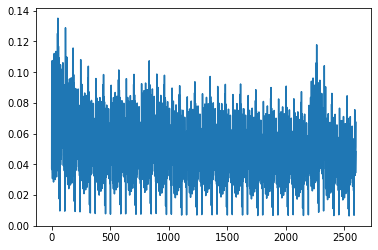

In [9]:
plt.plot(lossValuesDevSet)

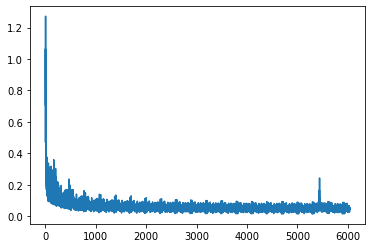

In [10]:
plt.plot(lossValuesTrainingSet)

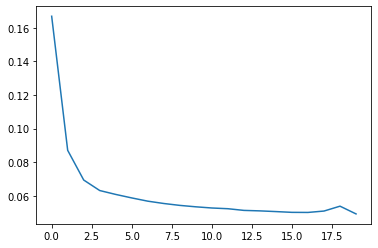

In [11]:
plt.plot(lossValuesEpoch)

In [52]:
# Test set
# PLANTEAMOS UN CONJUNTO DE TESTEO ROTADO PARA VER LOS RESULTADOS

trainingSet = dict([('input',train_noisyImage), ('output', train_groundTruth)])

inputsTestSet = torch.from_numpy(trainingSet['input'][:,:,:,:])
groundTruthTestSet = torch.from_numpy(trainingSet['output'][:,:,:,:])

inputsTestSet = torchvision.transforms.functional.rotate(inputsTestSet,15)
groundTruthTestSet = torchvision.transforms.functional.rotate(groundTruthTestSet,15)

def MSE(img1, img2):
    cuadradoDeDif = ((img1 - img2) ** 2)
    suma = np.sum(cuadradoDeDif)
    cantPix = img1.shape[0] * img1.shape[1]  # img1 and 2 should have same shape
    error = suma / cantPix
    return error

msePre = []

for i in range(0,inputsTestSet.shape[0]):
    img1 = (inputsTestSet[i]).detach().numpy()
    img2 = (groundTruthTestSet[i]).detach().numpy()
    msePre.append(MSE(img1[0,:,:],img2[0,:,:]))
    
print(np.mean(msePre))

In [ ]:
## Testeo ....
outArray = []

for i in range(0,inputsTestSet.shape[0]):
    inputs =  inputsTestSet[i]
    inputs = torch.unsqueeze(inputs, dim = 0)
    out = unet(inputs)
    outArray.append(out)